In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir, get_ME_model, load_DSNs,  \
                              get_system_from_template, get_arch_from_template
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
from dsn.util.plot_util import PCA
from tf_util.tf_util import load_dgm, dgm_hessian

import os

os.chdir('../../')

class stg_circuit:
    def __init__(self, dt=0.025, T=2400, fft_start=400, w=40):
        self.dt = dt
        self.T = T
        self.fft_start = fft_start
        self.w = w
        """V_m0 = -65.0e-3*np.ones((5,))
        N_0 = 0.25*np.ones((5,))
        H_0 = 0.1*np.ones((5,))
        self.init_conds = np.concatenate((V_m0, N_0, H_0), axis=0)"""
        self.init_conds = np.array(
            [
                -0.04169771,
                -0.04319491,
                0.00883992,
                -0.06879824,
                0.03048103,
                0.00151316,
                0.19784773,
                0.56514935,
                0.12214069,
                0.35290397,
                0.08614699,
                0.04938177,
                0.05568701,
                0.07007949,
                0.05790969,
            ]
        )

    def simulate(self, g_el, g_synA, g_synB):
        # define fixed parameters

        # conductances
        C_m = 1.0e-9

        # volatages
        V_leak = -40.0e-3  # 40 mV
        V_Ca = 100.0e-3  # 100mV
        V_k = -80.0e-3  # -80mV
        V_h = -20.0e-3  # -20mV
        V_syn = -75.0e-3  # -75mV
        
        v_1 = 0.0  # 0mV
        v_2 = 20.0e-3  # 20mV
        v_3 = 0.0  # 0mV
        v_4 = 15.0e-3  # 15mV
        v_5 = 78.3e-3  # 78.3mV
        v_6 = 10.5e-3  # 10.5mV
        v_7 = -42.2e-3  # -42.2mV
        v_8 = 87.3e-3  # 87.3mV
        v_9 = 5.0e-3  # 5.0mV

        v_th = -25.0e-3  # -25mV

        # neuron specific conductances
        g_Ca_f = 1.9e-2 * (1e-6)  # 1.9e-2 \mu S
        g_Ca_h = 1.7e-2 * (1e-6)  # 1.7e-2 \mu S
        g_Ca_s = 8.5e-3 * (1e-6)  # 8.5e-3 \mu S

        g_k_f = 3.9e-2 * (1e-6)  # 3.9e-2 \mu S
        g_k_h = 1.9e-2 * (1e-6)  # 1.9e-2 \mu S
        g_k_s = 1.5e-2 * (1e-6)  # 1.5e-2 \mu S

        g_h_f = 2.5e-2 * (1e-6)  # 2.5e-2 \mu S
        g_h_h = 8.0e-3 * (1e-6)  # 8.0e-3 \mu S
        g_h_s = 1.0e-2 * (1e-6)  # 1.0e-2 \mu S

        g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
        g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
        g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

        g_leak = 1.0e-4 * (1e-6)  # 1e-4 \mu S

        phi_N = 2  # 0.002 ms^-1

        def f(x, g_el, g_synA, g_synB):
            # x contains
            V_m = x[:5]
            N = x[5:10]
            H = x[10:]

            M_inf = 0.5 * (1.0 + np.tanh((V_m - v_1) / v_2))
            N_inf = 0.5 * (1.0 + np.tanh((V_m - v_3) / v_4))
            H_inf = 1.0 / (1.0 + np.exp((V_m + v_5) / v_6))

            S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))

            I_leak = g_leak * (V_m - V_leak)
            I_Ca = g_Ca * M_inf * (V_m - V_Ca)
            I_k = g_k * N * (V_m - V_k)
            I_h = g_h * H * (V_m - V_h)

            I_elec = np.array(
                [
                    0.0,
                    g_el * (V_m[1] - V_m[2]),
                    g_el * (V_m[2] - V_m[1] + V_m[2] - V_m[4]),
                    0.0,
                    g_el * (V_m[4] - V_m[2]),
                ]
            )

            I_syn = np.array(
                [
                    g_synB * S_inf[1] * (V_m[0] - V_syn),
                    g_synB * S_inf[0] * (V_m[1] - V_syn),
                    g_synA * S_inf[0] * (V_m[2] - V_syn)
                    + g_synA * S_inf[3] * (V_m[2] - V_syn),
                    g_synB * S_inf[4] * (V_m[3] - V_syn),
                    g_synB * S_inf[3] * (V_m[4] - V_syn),
                ]
            )

            I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn

            lambda_N = (phi_N) * np.cosh((V_m - v_3) / (2 * v_4))
            tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0

            dVmdt = (1.0 / C_m) * (-I_total)
            dNdt = lambda_N * (N_inf - N)
            dHdt = (H_inf - H) / tau_h

            dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
            return dxdt

        x = self.init_conds
        xs = [x]
        for t in range(self.T):
            dxdt = f(x, g_el, g_synA, g_synB)
            x = dxdt * self.dt + x
            xs.append(x)
        X = np.array(xs)

        return X

### Find the best converged model and plot. ###

In [2]:
sysname = 'STGCircuit'

freq = "med"
param_dict = {"freq":freq}
system = get_system_from_template(sysname, param_dict)

num_masks = 4
nlayers = 2
sigma_init = 0.5
arch_params = {
               'D':system.D,
               'repeats':1,
               'num_masks':num_masks,
               'nlayers':nlayers,
               'sigma_init':sigma_init,
               'post_affine':True,
              }
param_dict.update(arch_params)
arch_dict = get_arch_from_template(system, param_dict)

In [3]:
# multivariate normal initialization variance
c_init_ords = np.array([2])
start_rs = 1
num_rs = 1
random_seeds = np.arange(start_rs, num_rs+start_rs)

In [4]:
dirstr = '11_13_19'

In [57]:
best_models = []
ME_its = []

alpha=0.05
frac_samps=0.10

conv_dict = {
    'alpha':alpha,
    'frac_samples':frac_samps,
    'tol':0.0,
    'tol_inds':[]
}
    
best_model, max_ME, ME_it, first_it = get_ME_model(system, arch_dict, c_init_ords, \
                                                   random_seeds, dirstr, 
                                                   conv_dict)
            
print(best_model)
print(ME_it)

0 ------------------
thresh 0.005
0 pvals [0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0]
1 pvals [0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.45, 0.0]
2 pvals [0.25, 0.0, 0.0, 0.85, 0.01, 0.01, 0.04, 0.05, 0.82, 0.05]
3 pvals [0.0, 0.13, 0.35, 0.03, 0.51, 0.09, 0.44, 0.68, 0.81, 0.36]
4 pvals [0.02, 0.63, 0.16, 0.7, 0.26, 0.01, 0.13, 0.19, 0.42, 0.14]
models/11_13_19/STGCircuit_g_el_g_synA_freq_mu=5.30E-01_5.30E-01_5.30E-01_5.30E-01_5.30E-01_6.25E-04_6.25E-04_6.25E-04_6.25E-04_6.25E-04_flow=1R_4M_2L_10U_M_A_iso_std=0.5_sigma=0.50_c=2_rs=1/
4


In [6]:
from dsn.util.dsn_util import load_DSN_fast

tf_vars, feed_dict = load_DSN_fast(system, arch_dict, best_model, ME_it)


Loaded params from optimization.
0 [<tf.Tensor 'Const:0' shape=(1, 1296) dtype=float64>] [(1, 1296)]
j 0 theta_1_1
Instructions for updating:
Colocations handled automatically by placer.
params Tensor("DensityNetwork/Layer1/concat:0", shape=(1, 1296), dtype=float64)
0 Z Tensor("Placeholder:0", shape=(1, ?, 2), dtype=float64)
j 0 theta_2_1
post mult params Tensor("DensityNetwork/PostMultLayer/concat:0", shape=(1, 2), dtype=float64)
j 0 theta_3_1
post shift params Tensor("DensityNetwork/PostShiftLayer/concat:0", shape=(1, 2), dtype=float64)


(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x135473908>)

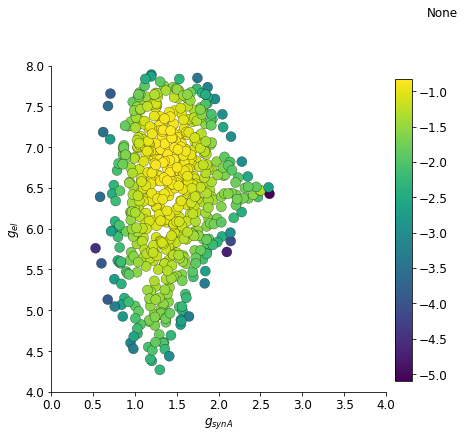

In [7]:
M = 600
W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_vars

_W = np.random.normal(0.0, 1.0, (1,M,system.D))
_Z_input_dummy = np.zeros((1,1,system.D))
feed_dict.update({W:_W, Z_input:_Z_input_dummy})
model_sess = tf.Session()

model_sess.run(tf.global_variables_initializer())
_Z_samp, _log_q_Z_samp = model_sess.run([Z, log_q_Z], feed_dict)

pairplot(_Z_samp[0], range(2), system.z_labels, c=_log_q_Z_samp[0],
         xlims=[0, 4], ylims=[4, 8], figsize=(6,6))

In [8]:
z_max_inds = np.argsort(-_log_q_Z_samp[0])
z_max_ind = z_max_inds[0]
print(_Z_samp[:,z_max_ind,:])

[[6.93838135 1.40817173]]


In [6]:
"""sessions, tf_vars, feed_dicts = load_DSNs([best_model], [ME_it])
print('done loading model!')

M = 10000
model_sess = sessions[0]
W, Z, Z_input, Z_INV, log_q_Z, batch_norm_mus, batch_norm_sigmas, batch_norm_means, batch_norm_vars = tf_vars[0]
feed_dict = feed_dicts[0]



"""

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/STGCircuit_sigma=0.10/STGCircuit_g_el_g_synA_freq_mu=5.42E-01_5.42E-01_5.42E-01_5.42E-01_5.42E-01_6.25E-04_6.25E-04_6.25E-04_6.25E-04_6.25E-04_flow=1R_4M_2L_10U_M_A_c=10_rs=3/model-4
Loaded DGM in 1338.70 seconds
here 1
done loading model!


In [9]:
hess_fname = 'data/STGCircuit/hess_%.2f.npz' % sigma_init
if (os.path.exists(hess_fname)):
    print('loading hessian')
    hess_file = np.load(hess_fname)
    _H = hess_file['H']
    w_max = hess_file['w_max']
    z_max = hess_file['z_max']
    z_max_inv = hess_file['z_max_inv']
    print('done')
else:
    T_x = system.compute_suff_stats(Z)
    print('T_x ready')

    """    #Get large sample from model to estimate mode
    print('sampling')
    _W = np.random.normal(0.0, 1.0, (1,M,system.D))
    feed_dict.update({W:_W})
    _Z, _T_x, _log_q_Z = model_sess.run([Z, T_x, log_q_Z], feed_dict)
    print('done')"""

    print('calc hess for STG')
    H = dgm_hessian(log_q_Z, W, Z_input, Z_INV)
    print(H)

    z_max_inds = np.argsort(-_log_q_Z_samp[0])
    z_max_ind = z_max_inds[0]
    z_max = np.expand_dims(_Z_samp[:,z_max_ind,:], 1)
    w_max = np.expand_dims(_W[:,z_max_ind,:], 1)
    feed_dict.update({W:w_max, Z_input:z_max})

    print('executing hess')
    _H = model_sess.run(H, feed_dict)
    print('H', _H)
    z_max_inv, _log_q_z = model_sess.run([Z_INV, log_q_Z], feed_dict)

    np.savez(hess_fname, H=_H, z_max=z_max, w_max=w_max, z_max_inv=z_max_inv)

print(z_max)

D, V = np.linalg.eig(_H)

inds = np.argsort(D)
D = D[inds]
V = V[:,inds]

v1 = V[:,0]
v2 = V[:,1]

loading hessian
done
[[[7.02034037 1.38611358]]]


In [10]:
print(D)

[-10.90323588  -2.33907621]


In [12]:
"""hess_fname = 'data/STGCircuit/hess.npz'
print('loading hessian')
hess_file = np.load(hess_fname)
_H = hess_file['H']
w_max = hess_file['w_max']
z_max = hess_file['z_max']
z_max_inv = hess_file['z_max_inv']
print('done')

v1 = V[:,0]
v2 = V[:,1]"""

"hess_fname = 'data/STGCircuit/hess.npz'\nprint('loading hessian')\nhess_file = np.load(hess_fname)\n_H = hess_file['H']\nw_max = hess_file['w_max']\nz_max = hess_file['z_max']\nz_max_inv = hess_file['z_max_inv']\nprint('done')\n\nv1 = V[:,0]\nv2 = V[:,1]"

ticks None
0
dist (300, 2)
not saving figure


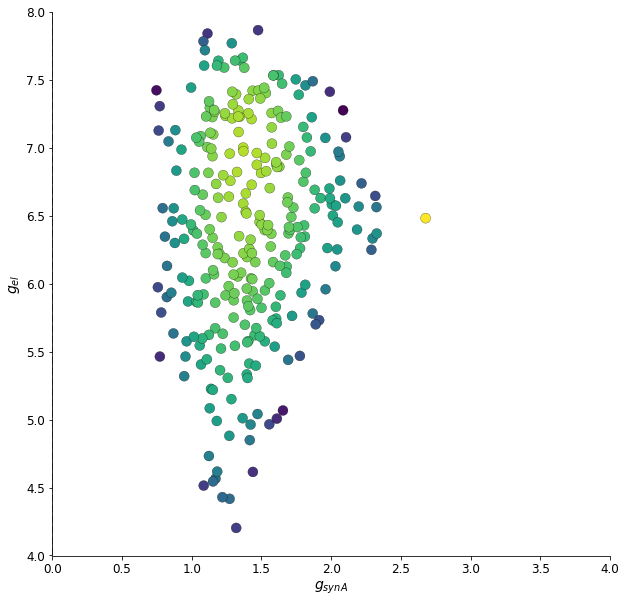

In [12]:
"""Zs, cs, axs = dsn_pairplots([best_model], 'Zs', system, [ME_it],
                            xlims=[0,4], ylims=[4, 8])
"""

-6.407358075525745


ticks None
0
dist (300, 10)
not saving figure


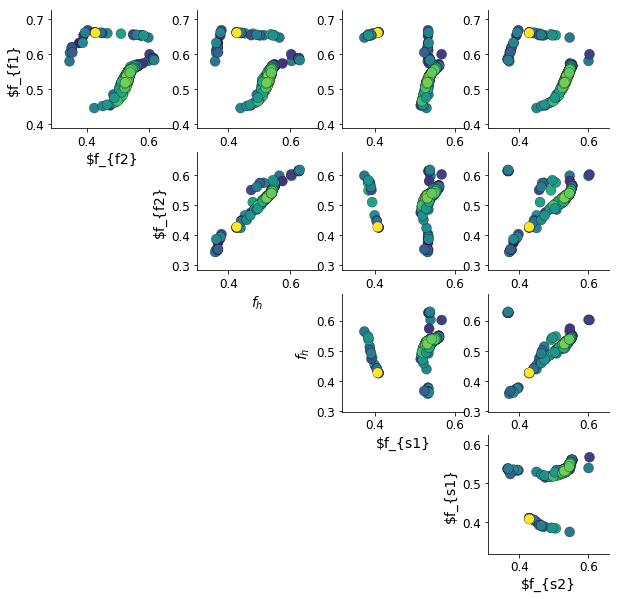

In [14]:
"""T_xs, cs, axs = dsn_pairplots([best_model], 'T_xs', system,  [ME_it], D=5)"""

### Sensitivity analysis. ###

In [ ]:
"""hess_fname = 'data/STGCircuit/hess.npz'
if (os.path.exists(hess_fname)):
    print('loading hessian')
    hess_file = np.load(hess_fname)
    _H = hess_file['H']
    w_max = hess_file['w_max']
    z_max = hess_file['z_max']
    z_max_inv = hess_file['z_max_inv']
    print('done')
else:
    sessions, tf_vars, feed_dicts = load_DSNs([best_model], [ME_it])
    print('done loading model!')

    M = 10000
    sess = sessions[0]
    W, Z, Z_input, Z_INV, log_q_Z, batch_norm_mus, batch_norm_sigmas, batch_norm_means, batch_norm_vars = tf_vars[0]
    feed_dict = feed_dicts[0]

    T_x = system.compute_suff_stats(Z)
    print('T_x ready')

    #Get large sample from model to estimate mode
    print('sampling')
    _W = np.random.normal(0.0, 1.0, (1,M,system.D))
    feed_dict.update({W:_W})
    _Z, _T_x, _log_q_Z = sess.run([Z, T_x, log_q_Z], feed_dict)
    #Zs.append(_Z)
    #T_xs.append(_T_x)
    print('done')

    print('calc hess for STG')
    H = dgm_hessian(log_q_Z, W, Z_input, Z_INV)
    print(H)

    z_max_inds = np.argsort(-_log_q_Z[0])
    z_max_ind = z_max_inds[0]
    z_max = np.expand_dims(_Z[:,z_max_ind,:], 1)
    w_max = np.expand_dims(_W[:,z_max_ind,:], 1)
    feed_dict.update({W:w_max, Z_input:z_max})

    print('executing hess')
    _H = sess.run(H, feed_dict)
    print('H', _H)
    z_max_inv, _log_q_z = sess.run([Z_INV, log_q_Z], feed_dict)

    np.savez(hess_fname, H=_H, z_max=z_max, w_max=w_max, z_max_inv=z_max_inv)

D, V = np.linalg.eig(_H)

inds = np.argsort(D)
D = D[inds]
V = V[:,inds]"""

## Simulate system figs

### Product-quality DSN distribution. ###

In [11]:
Z_tf = tf.placeholder(tf.float64, (1,None,system.D))
T_x_tf = system.compute_suff_stats(Z_tf)

In [12]:
xlim = [0,4]
ylim = [4,8]

K = 51
x = np.linspace(xlim[0], xlim[1], K)
y = np.linspace(ylim[0], ylim[1], K)
m = K**2

Z_mesh = np.meshgrid(x, y, indexing='ij')
_Z_grid = np.zeros((1,m,system.D))
_Z_grid[0,:,0] = np.reshape(Z_mesh[1], (m,))
_Z_grid[0,:,1] = np.reshape(Z_mesh[0], (m,))

with tf.Session() as sess:
    _T_x = sess.run(T_x_tf, {Z_tf:_Z_grid})
print(_T_x.shape)

mu_err = np.mean(np.square(_T_x[0,:,:5]-np.expand_dims(system.mu[:5], 0)), axis=1)
mu_err_mesh = np.reshape(mu_err, (K, K))


(1, 2601, 10)


In [13]:
mu_err = np.mean(np.square(_T_x[0,:,:]-np.expand_dims(system.mu, 0)), axis=1)
#mu_err = np.var(_T_x[0,:,:5], axis=1)
mu_err_mesh = np.reshape(mu_err, (K, K))

In [14]:
"""_Z = np.expand_dims(Zs[0], 0)
_log_q_Z = np.expand_dims(cs[0], 0)
Z_max = z_max[0,0,:]
print(_Z.shape, _log_q_Z.shape, Z_max.shape)"""

'_Z = np.expand_dims(Zs[0], 0)\n_log_q_Z = np.expand_dims(cs[0], 0)\nZ_max = z_max[0,0,:]\nprint(_Z.shape, _log_q_Z.shape, Z_max.shape)'

In [15]:
red = '#ff3333'
orange = '#ff7700'
purple = '#9900ff'

In [16]:
_Z = _Z_samp
_log_q_Z = _log_q_Z_samp
Z_max = z_max[0,0,:]

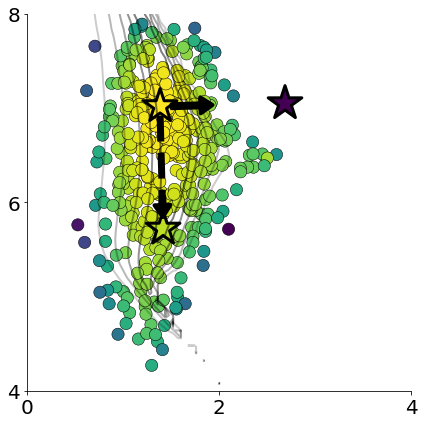

In [42]:
delta = 1.3
Z_test = np.array([[z_max[0,0,0], z_max[0,0,1]],
                   [z_max[0,0,0] + delta*v1[0], z_max[0,0,1] + delta*v1[1]],
                   [z_max[0,0,0] - delta*v2[0], z_max[0,0,1] - delta*v2[1]]])
Z_test = np.expand_dims(Z_test, 0)

size = 150

_W = np.zeros((1,1,2))
feed_dict.update({W:_W, Z_input:Z_test})
_Z_INV = model_sess.run(Z_INV, feed_dict)
_W = np.zeros((1,1,2))
feed_dict.update({W:_Z_INV, Z_input:np.zeros((1,1,2))})
_Z_test, _log_q_Z_test = model_sess.run([Z, log_q_Z], feed_dict)

_n = Z_test.shape[1]

xlim = [0,4]
ylim = [4,8]

n = 400
fontsize = 24
figsize = (6,6)
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=figsize)
ax = plt.subplot(1,1,1)
Z_plot = np.concatenate((_Z[:,:n,:], Z_test), axis=1)
_log_q_Z_test_cbar = _log_q_Z_test
_log_q_Z_test_cbar[0,1] = np.min(_log_q_Z[0,:n])
c_plot = np.concatenate((_log_q_Z[0,:n], _log_q_Z_test_cbar[0]), axis=0)
sc = ax.scatter(Z_plot[0,:,1], Z_plot[0,:,0], s=size, c=c_plot, 
           linewidths=0.5, edgecolor='k')
colors_plot = sc.to_rgba(c_plot)
colors_test = colors_plot[n:]
s = 1.8
lw = 4
star_xbuf = 0.12
star_ybuf = 0.1

v1_start = (Z_max[1]+star_xbuf, Z_max[0])
v1_end = (Z_max[1] + (s / np.sqrt(np.abs(D[0])))*V[1,0], (Z_max[0] + (s / np.sqrt(np.abs(D[0])))*V[0,0]))

v2_start = (Z_max[1], Z_max[0]-star_ybuf)
v2_end = (Z_max[1] - (s / np.sqrt(np.abs(D[1])))*V[1,1], (Z_max[0] - (s / np.sqrt(np.abs(D[1])))*V[0,1]))

ratio = 0.8
v2_mid = ((1-ratio)*v2_start[0]+ratio*v2_end[0], (1-ratio)*v2_start[1]+ratio*v2_end[1])

#levels = [2e-6, 2e-5, 2e-4]
levels = [2.5e-5, 5e-5, 1e-4, 2e-4, 4e-4]
num_levels = len(levels)
alphas = np.linspace(0.5, 0.2, num_levels)
colors = []
for i in range(num_levels):
    colors.append(np.array([0,0,0,alphas[i]]))
ax.contour(Z_mesh[0], Z_mesh[1], mu_err_mesh, levels, colors=colors)

color1 = '#cc3300'
color2 = '#666699'
gray = 0.2*np.array([1,1,1])
ax.plot([v2_start[0], v2_mid[0]], [v2_start[1], v2_mid[1]], 'k--', lw=7)
ax.annotate("", xy=v1_end, xytext=v1_start, arrowprops=dict(headwidth=16, lw=4, color='k'))#colors_test[1]))
ax.annotate("", xy=v2_end, xytext=v2_mid, arrowprops=dict(headwidth=16, lw=4, color='k'))#colors_test[2]))

msize = 15
#for i in range(_n):    
    #ax.plot(Z_test[0,:,1], Z_test[0,i,0], 'k*', markersize=msize+8)
ax.scatter(Z_test[0,:,1], Z_test[0,:,0], s=1250, c=_log_q_Z_test_cbar[0,:],
           marker='*', linewidths=3.0, edgecolor='k')

savepath = '../written/NN2019/figures/fig1/'
#ax.set_xlabel(system.z_labels[1], fontsize=fontsize)
#ax.set_ylabel(system.z_labels[0], fontsize=fontsize)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
xticks = [0, 2, 4]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=fontsize-4)
yticks = [4, 6, 8]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=fontsize-4)
plt.tight_layout()
plt.savefig(savepath + 'STG_EPI.pdf')
plt.show()

In [116]:
print(_log_q_Z_test)

[[-0.81995157 -4.9110511  -1.20799086]]


In [117]:
savepath = '../written/NN2019/figures/fig1/'

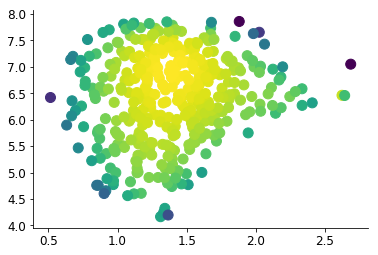

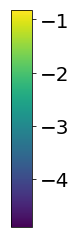

In [118]:
# get colorbars
from dsn.util.plot_util import filter_outliers

plt.figure()
h = plt.scatter(Z_plot[0,:,1], Z_plot[0,:,0], c=c_plot, cmap=cmap)
fig,ax = plt.subplots()
cbar = plt.colorbar(h,ax=ax, ticks = [-1,-2,-3,-4], aspect=10)
cbar.ax.tick_params(labelsize=20) 
ax.remove()
plt.savefig(savepath + 'colorbar.pdf', transparent=True)
plt.show()

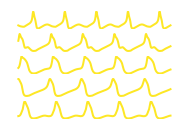

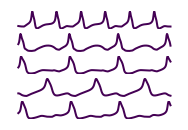

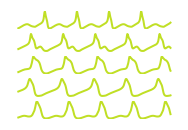

In [109]:
model = stg_circuit(dt=0.025, T=2000, fft_start=0, w=20)
_n = 3
T = 350
t = np.linspace(0, (T-1)*system.dt, T)
cmap = plt.get_cmap('viridis')
neurons = ['f1', 'f2', 'h', 's1', 's2']
num_neurons = len(neurons)
figsize = (3,num_neurons*0.4)
for i in range(_n):
    fig, axs = plt.subplots(5, 1, figsize=figsize)
    g_el = Z_test[0,i,0]
    g_synA = Z_test[0,i,1]
    x_i = model.simulate(1e-9*g_el, 1e-9*g_synA, 5e-9)
    for k in range(num_neurons):
        axs[k].plot(t, x_i[-T:,k], color=colors_test[i], lw=2)
        axs[k].spines['bottom'].set_visible(False)
        axs[k].spines['left'].set_visible(False)
        axs[k].set_xticks([])
        axs[k].set_yticks([])
    plt.savefig(savepath + 'v_%s_z%d.png' % (neurons[k], i+1), transparent=True)
    plt.show()

In [71]:
from dsn.util.dsn_util import get_perturbs
n_perturb = 100
z0 = z_max

print(Z_tf)
print(T_x_tf)
T_x_perturbs, delta_perturbs, Z_perturbs = get_perturbs(system, V, z0, n_perturb, Z=Z_tf, T_x=T_x_tf)

ncirc = 100
alphas = np.zeros((ncirc,))
betas = np.zeros((ncirc,))
thetas = (np.pi*np.arange(ncirc)) / ncirc
V_circ = np.array([np.cos(thetas), np.sin(thetas)])

T_x_perturbs_circ, delta_perturbs_circ, Z_perturbs_circ = get_perturbs(system, V_circ, z0, n_perturb, Z=Z_tf, T_x=T_x_tf)

def calc_sensitivity(delta, d):
    abs_delta = np.abs(delta)
    m, b, r, p, stderr = scipy.stats.linregress(abs_delta, d)
    return m

# calculate distance for each DSN sample
d_v1 = np.sqrt(np.sum(np.square(T_x_perturbs[0,:,:5] - np.expand_dims(system.mu[:5], 0)), axis=1))
d_v2 = np.sqrt(np.sum(np.square(T_x_perturbs[1,:,:5] - np.expand_dims(system.mu[:5], 0)), axis=1))

# calculate DSN distribution on hessian eigenvectors 
v1 = V[:,0]
v2 = V[:,1]
theta1 = np.arctan(v1[1]/v1[0])
theta2 = np.arctan(v2[1]/v2[0]) + np.pi
print('Hess eigvec 1')
beta_1 = calc_sensitivity(delta_perturbs[0], d_v1)
print('theta', theta1, 'beta', beta_1)
print('Hess eigvec 2')
beta_2 = calc_sensitivity(delta_perturbs[1], d_v2)
print('theta', theta2, 'beta', beta_2)



Tensor("Placeholder_2:0", shape=(1, ?, 2), dtype=float64)
Tensor("concat_430:0", shape=(1, ?, 10), dtype=float64)
Hess eigvec 1
theta 1.5469362156267905 beta 0.2660578394087338
Hess eigvec 2
theta 3.117732542421687 beta 0.017178250279811937


In [ ]:
"""def calc_sensitivity(Z, v, z0, d):
    Z_c = Z - np.expand_dims(z0, 0)
    Z_v = np.dot(Z, v)
    abs_Z_v = np.abs(Z_v)
    m, b, r, p, stderr = scipy.stats.linregress(abs_Z_v, d)
    return m"""

1.5469362156267905 3.117732542421687


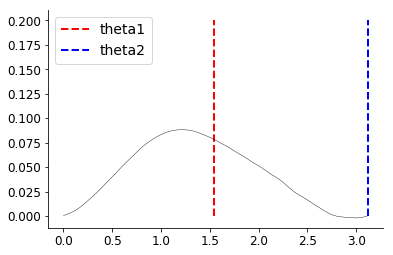

In [87]:
theta1 = np.arctan(v1[1]/v1[0])
theta2 = np.arctan(v2[1]/v2[0]) + np.pi
print(theta1, theta2)
maxds = np.array([0.4])
plt.figure()
ymin = 0
ymax = 0.2
ys = [ymin, ymax]

plt.plot([theta1, theta1], ys, 'r--')
plt.plot([theta2, theta2], ys, 'b--')
for i in range(maxds.shape[0]):
    maxd = maxds[i]
    buf_ind = maxd
    halfd = (n_perturb // 2)
    min_ind = int(halfd - maxd*halfd)
    max_ind = int(halfd + maxd*halfd)

    betas = np.zeros((ncirc,))

    for i in range(ncirc):
        d = np.sqrt(np.sum(np.square(T_x_perturbs_circ[i,min_ind:max_ind,:] - np.expand_dims(system.mu[:], 0)), axis=1))
        betas[i] = calc_sensitivity(delta_perturbs_circ[i,min_ind:max_ind], d)

    plt.plot(thetas, betas, 'k', lw=maxd)

plt.legend(['theta1', 'theta2'])
plt.show()

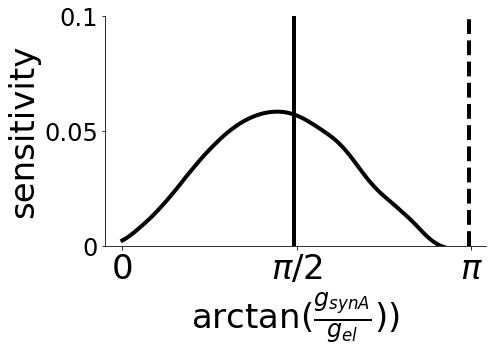

In [89]:
fontsize = 24
lw = 4

maxds = np.arange(0.1,1.0,0.1)
plt.figure(figsize=(7,5))
ymin = 0
ymax = 0.2
ys = [ymin, ymax]
plt.plot([theta1, theta1], ys, 'k-', lw=lw)
plt.plot([theta2, theta2], ys, 'k--', lw=lw)
maxd = 0.25
buf_ind = maxd
halfd = (n_perturb // 2)
min_ind = int(halfd - maxd*halfd)
max_ind = int(halfd + maxd*halfd)

betas = np.zeros((ncirc,))

for i in range(ncirc):
    d = np.sqrt(np.sum(np.square(T_x_perturbs_circ[i,min_ind:max_ind,:] - np.expand_dims(system.mu[:], 0)), axis=1))
    betas[i] = calc_sensitivity(delta_perturbs_circ[i,min_ind:max_ind], d)

plt.plot(thetas, betas, 'k', lw=lw)
ax = plt.gca()

#plt.legend([r'$v_1 \angle$', r'$v_2 \angle$'], fontsize=fontsize, loc=1)
plt.xlabel(r'$\arctan(\frac{g_{synA}}{g_{el}}))$', fontsize=fontsize+10)
plt.ylabel('sensitivity', fontsize=fontsize+10)
ax.set_xticks([0, np.pi/2,np.pi])
ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$'], fontsize=fontsize+10)
ax.set_yticks([0, 0.05, 0.1])
ax.set_yticklabels([0, 0.05, 0.1], fontsize=fontsize)
ax.set_ylim([0, 0.1])
plt.tight_layout()
plt.savefig(savepath + 'sensitivity_inset2.pdf', transparent=True)
plt.show()

### Product-quality simulated activity. ###

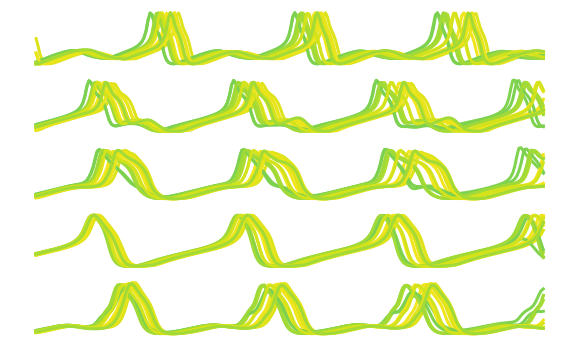

In [108]:
model = stg_circuit(dt=0.025, T=500, fft_start=0, w=20)

savepath = '../written/NN2019/figures/fig1/'
T_start = 100
T = 350
t = np.linspace(T_start*system.dt, (T-1)*system.dt, T-T_start)
cmap = plt.get_cmap('viridis')
neurons = ['f1', 'f2', 'h', 's1', 's2']
num_neurons = len(neurons)
figsize = (10,num_neurons*1.2)
fig, axs = plt.subplots(5, 1, figsize=figsize)
for i in range(5,20):
    g_el = Z_plot[0,i,0]
    g_synA = Z_plot[0,i,1]
    x_i = model.simulate(1e-9*g_el, 1e-9*g_synA, 5e-9)
    for k in range(num_neurons):
        axs[k].plot(t, x_i[T_start:T,k], color=colors_plot[i], lw=3.0)
        axs[k].spines['bottom'].set_visible(False)
        axs[k].spines['left'].set_visible(False)
        axs[k].set_xticks([])
        axs[k].set_yticks([])
plt.savefig(savepath + 'STG_EP.pdf', transparent=True)
plt.show()

## Show convergence of EPI

In [44]:
npzfile = np.load(best_model + 'opt_info.npz')

Hs = npzfile['Hs']
mean_T_xs = npzfile['mean_T_xs']
check_rate = npzfile['check_rate']
epoch_inds = npzfile['epoch_inds']

print('Hs', Hs.shape)
print('mean_T_xs', mean_T_xs.shape)
print('check_rate', check_rate)
print('epoch_inds', epoch_inds)

iterations = np.arange(0, epoch_inds[ME_it]+1, check_rate)
conv_ind = iterations.shape[0]

Hs (251,)
mean_T_xs (251, 10)
check_rate 100
epoch_inds [    0  2500  5000  7500 10000 12500 15000 17500 20000 22500 25000]


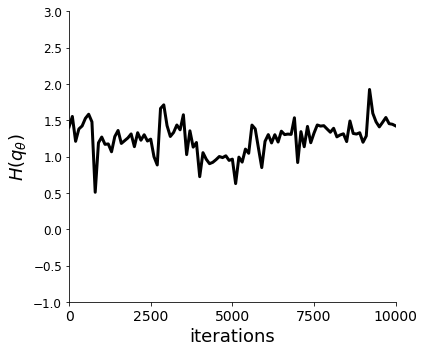

In [53]:
savepath = '../written/NN2019/figures/figS5/'

fontsize = 18
xticks = epoch_inds[:(ME_it+1)]

figsize = (6, 5)

plt.figure(figsize=figsize)
plt.plot(iterations, Hs[:conv_ind], 'k', lw=3)
plt.xticks(xticks, fontsize=fontsize-4)
plt.xlim([0, iterations[-1]])
plt.ylim([-1, 3])
plt.xlabel('iterations', fontsize=fontsize)
plt.ylabel(r'$H(q_\theta)$', fontsize=fontsize)
plt.tight_layout()
plt.savefig(savepath + 'H.pdf')
plt.show()

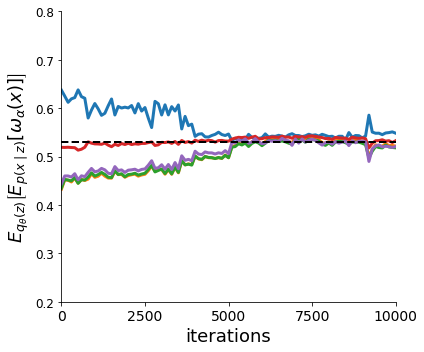

In [54]:
plt.figure(figsize=figsize)
plt.plot(iterations, mean_T_xs[:conv_ind, :5], lw=3)
plt.plot([iterations[0], iterations[-1]], [system.mu[0], system.mu[0]], 'k--', lw=2)
plt.xticks(xticks, fontsize=fontsize-4)
plt.xlim([0, iterations[-1]])
plt.xlabel('iterations', fontsize=fontsize)
plt.ylabel(r'$E_{q_\theta(z)} \left[E_{p(x \mid z)} \left[\omega_\alpha(x) \right] \right]$', fontsize=fontsize)
plt.ylim([.2, .8])
plt.tight_layout()
plt.savefig(savepath + 'T_x1.pdf')
plt.show()

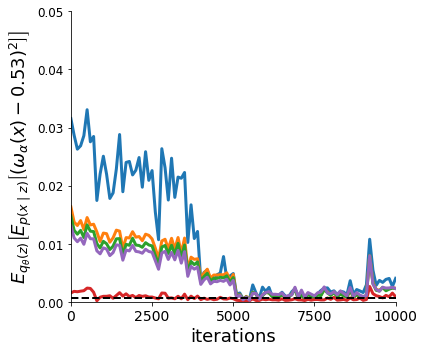

In [55]:
plt.figure(figsize=figsize)
plt.plot(iterations, mean_T_xs[:conv_ind, 5:], lw=3)
plt.plot([iterations[0], iterations[-1]], [system.mu[5], system.mu[5]], 'k--'"")
plt.xticks(xticks, fontsize=fontsize-4)
plt.xlim([0, iterations[-1]])
plt.xlabel('iterations', fontsize=fontsize)
plt.ylabel(r'$E_{q_\theta(z)} \left[E_{p(x \mid z)} \left[(\omega_\alpha(x)-%.2f)^2 \right] \right]$' % system.mu[0], fontsize=fontsize)
plt.ylim([0.0, 0.05])
plt.tight_layout()
plt.savefig(savepath + 'T_x2.pdf')
plt.show()